# Portfolio Optimization with PyPortfolioOpt

This notebook contains code to optimize a portfolio of equities according to Modern Portfolio Theory. Given a list of stocks and a time frame, the portfolio weighted for minimum volatility along the Markowitz Efficient Frontier will be computed. I used these calculations to present investing ideas to an investment club that I am a partner of. The libraries used for this project are listed below.

In [1]:
import pandas as pd
from pypfopt.cla import CLA
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import pypfopt
import pandas_datareader.data as datareader
import datetime as dt
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt

In C:\Users\CCCam\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\CCCam\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\CCCam\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\CCCam\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\CCCam\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Appreciation-Over-Time" data-toc-modified-id="Appreciation-Over-Time-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Appreciation Over Time</a></span></li></ul></li><li><span><a href="#Calculations" data-toc-modified-id="Calculations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculations</a></span><ul class="toc-item"><li><span><a href="#Expected-Returns" data-toc-modified-id="Expected-Returns-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Expected Returns</a></span></li><li><span><a href="#Volatility" data-toc-modified-id="Volatility-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Volatility</a></span></li><li><span><a href="#Efficient-Frontier" data-toc-modified-id="Efficient-Frontier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Efficient Frontier</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Performance" data-toc-modified-id="Performance-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Performance</a></span></li><li><span><a href="#Weights" data-toc-modified-id="Weights-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Weights</a></span></li><li><span><a href="#Number-of-Shares" data-toc-modified-id="Number-of-Shares-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Number of Shares</a></span></li></ul></li></ul></div>

## Data

### Loading Data

We start be selecting the time frame of data to use for our calculations. By default, this is set to 180 days. A smaller span would optimize the portfolio according to shorter term trends, while a larger span would optimize the portfolio according to longer term trends. 

In [2]:
#set span for calculation
span=180*1

Based on the selected time frame, we determine the start date and end date for the data that will be used. The end date is today's date, and the start date is the number of days before the start date that is stored in span. 

In [3]:
#get last date as today's date
end = date.today()

#get start date based on span
start = end -dt.timedelta(days=span)

print('Start Date:',start)
print('End Date:',end)

Start Date: 2020-07-02
End Date: 2020-12-29


Next, we specify the list of stocks that will compose our portfolio. The default list is a group of tickers that were discussed in the investment club I am a part of. 

In [4]:
#set stock tickers that will be used in portfolio
stocks = ['TSLA','MSFT','AAPL','AMD','BA','CCL','LUV','DAL','PFE','PG','MJ','TAN','KO']

The next step is to fetch the daily close prices for the stock tickers over the specified time period. We compile these in to a DataFrame; the first few rows of which are displayed below.

In [5]:
#create empty dataframe to hold historic price data
df = pd.DataFrame()

#fetch the historic price data for each stock and add the adjusted close price for each stock as a column in df
for stock in stocks:
    price_data = datareader.DataReader(stock,'yahoo',start=start,end=end)
    df[stock]=price_data['Adj Close']

df.head()

,TSLA,MSFT,AAPL,AMD,BA,CCL,LUV,DAL,PFE,PG,MJ,TAN,KO
Date,,,,,,,,,,,,,
2020-07-02,241.731995,205.225311,90.707176,52.340000,180.809998,15.88,34.119999,27.719999,32.094959,119.458687,12.633256,37.304214,44.173267
2020-07-06,274.316010,209.643036,93.133614,53.400002,187.910004,15.61,34.299999,28.440001,32.094959,120.199867,12.799483,39.202396,44.517757
2020-07-07,277.971985,207.205322,92.844635,52.930000,178.880005,14.57,33.009998,27.010000,31.648546,120.782936,12.789705,39.661957,44.498066
2020-07-08,273.175995,211.762360,95.006996,53.430000,180.080002,15.32,32.889999,27.010000,31.388144,121.445053,12.750593,41.540154,44.360275
2020-07-09,278.855988,213.244904,95.415558,57.259998,173.279999,14.58,31.570000,25.650000,31.118437,121.039879,12.476808,41.350334,43.218544


### Appreciation Over Time

Below is the appreciation for each of the stocks over the selected time period, if we were to invest $100 on the start date.

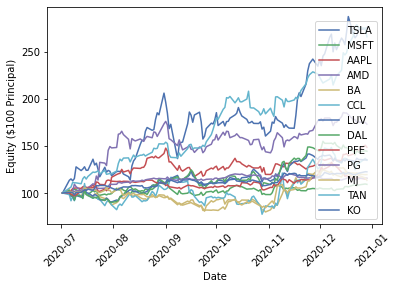

In [6]:
#standardize prices so that each stock starts at $100
standardized_df = df/df.iloc[0]*100

#plot equity in each stock if you started with a $100 principal
for stock in stocks:
    sns.lineplot(standardized_df.index,standardized_df[stock])

#format plot
plt.ylabel('Equity ($100 Principal)')
plt.xticks(rotation=45)
plt.legend(stocks)

plt.show()

## Calculations

### Expected Returns

We begin our computations by calculating mu, the mean historical returns for each of the stock tickers on the time interval. 

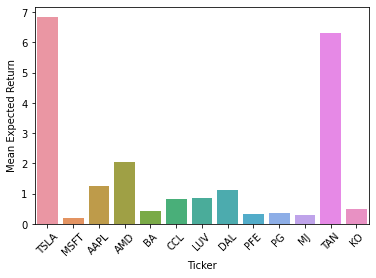

In [7]:
#calculate expected return
mu = expected_returns.mean_historical_return(df,frequency=252)

#plot expected returns
sns.barplot(mu.index,mu)
plt.xlabel('Ticker')
plt.ylabel('Mean Expected Return')
plt.xticks(rotation=45)
plt.show()

### Volatility

Next, we calculate sigma, the covariance matrix for the daily close prices of each stock. Shrinkage has been applied to increase stability.

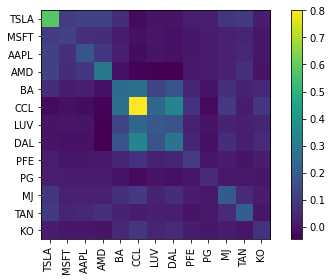

In [8]:
#calculate covariance
sigma = risk_models.CovarianceShrinkage(df,frequency=252).ledoit_wolf()

#plot covariance
plotting.plot_covariance(sigma)
plt.show()

### Efficient Frontier

Using mu and sigma, we compute the efficient frontier. We solve for the portfolio that minimizes volatility.

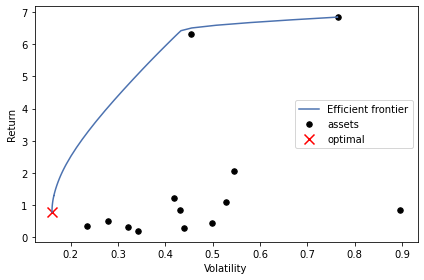

In [9]:
#compute efficient frontier
cla = CLA(mu,sigma)

#solve for minimum volatility portfolio
cla.min_volatility()

#plot efficiency curve
plotting.plot_efficient_frontier(cla)
plt.show()

## Evaluation

### Performance

We display the expected performance of the minimum volatility portfolio based on the historic data.

In [10]:
#display portfolio performance
print(cla.portfolio_performance(verbose=True))

Expected annual return: 79.3%
Annual volatility: 16.0%
Sharpe Ratio: 4.82
(0.7928451771722451, 0.16020711972784343, 4.82403764879575)


### Weights

Next, we show the weights of each stock in the minimum volatility portfolio.

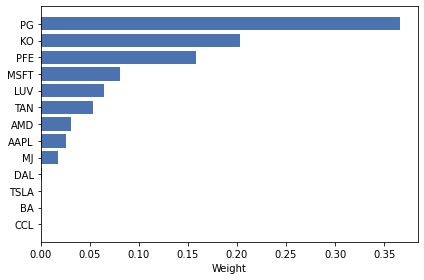

In [12]:
#plot weights
weights = cla.clean_weights()
plotting.plot_weights(weights)
plt.show()

### Number of Shares

Finally, we may select the amount of money to be invested in the portfolio, which can be used to determine the number of shares of each stock to buy.

In [13]:
#set portfolio amount
portfolio_amount=10000

The number of shares to buy for each stock are shown below. This is the minimum volatility portfolio for the selected portfolio size.

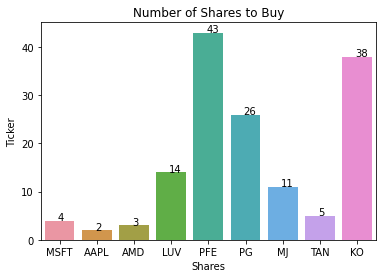

In [14]:
#calculate number of shares to buy
latest_prices = get_latest_prices(df)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=portfolio_amount)
allocation, leftover = da.lp_portfolio()

#plot number of shares to buy
sns.barplot(x=list(allocation.keys()),y=list(allocation.values()))
plt.title('Number of Shares to Buy')
plt.xlabel('Shares')
plt.ylabel('Ticker')

#add y-values to plot
i = -.05
for key in allocation.keys():
    plt.annotate(allocation[key], (i,allocation[key]+.075))
    i+=1

plt.show()